# Political Troll Tweets Analysis: China
---

**<u>_Objective:_</u>** In this project, we perform exploratory data analysis on Russian, Chinese and Indonesian information operations, to uncover the trolls' tradecraft and modus operandi against a target populace. This analysis wil enable intelligence and security entities to recognize and disrupt trolls waging information warfare.

---
# **Business Understanding**
---

Information warfare (_information operations / influence operations / IO_) is defined as the collection of data, and circulation of propaganda to gain strategic advantage over an adversary. The most notible aspect of such operations is the dissemination of disinformation, to exploit existing societal grievances and divisions. These methods aim to sow discord and distrust, influence the population's beliefs and manipulate public perception, steering the messes toward a direction beneficial to the adversary. A common technique of information operatives is to abuse popular social media platforms such as Twitter, Facebook or Instagram that has a very large user base and reach.

With the success of the Russian Internet Research Agency (IRA) in meddling with the US presidential election of 2016, other state actors are learning of this success and slowly, incorporate IO tradecraft. Given the proliferation of IO, it is pertinent that the defense community learn to detect, disrupt and dismantle IO that seeks to forment socio-politcal change. This area is a core tenant of counterintelligence work. With the large dataset publicly available, one can conduct data-driven intelligence analysis on the IO tweets.

In this project, we conduct a series of exploratory data analysis (EDA) on three countries - Russia, China and Indonesia - to analyze state-linked IO tradecraft. By analysing the publicly available datasets released by Twitter, we gain insight into the different kinds of tradecraft exploited by state actors. The series of EDA notebooks is an example of data-driven intelligence analysis. Furthermore, policy makers can use this insight to make better, informed decisions on national security issues.

---
## Data Understanding
---

Chinese state information operations are most commonly associated with influence operations - actively pursuing measures to shape public and international perception over issues such as Hong Kong and Taiwan.

---
# **Data Preparation**
---

We first download the following Russian datasets from IOA:

1. China_Changyu_Culture_Dec_2021.csv
2. China_May_2020.csv
3. China_S1_Aug_2019.csv
4. China_S2_Aug_2019.csv
5. China_S3_Sept_2019.csv
6. China_Xinjiang_Dec_2021.csv

The Chinese datsets have distinct names - _Changyu Culture_ and _Xinjiang_. For each of these datasets, we will select only the English language tweets, an randomly sample only half of the entire dataset. We then concatenate all of the samples together into one dataset

## Setups Configurations for Google Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# change the working directory
%cd '/content/drive/MyDrive/Data Science and Analytics Portfolio/2 Projects/2 Political Troll Tweets Analysis/2 Main/'

/content/drive/MyDrive/Data Science and Analytics Portfolio/2 Projects/2 Political Troll Tweets Analysis/2 Main


In [ ]:
#Download the various dependencies not available in Google Colab. Use the magic function to suppress the output
%%capture
!pip install bertopic
!pip install demoji
!pip install --upgrade tensorflow-gpu==2.15


In [ ]:
import os
cur_dir = os.getcwd()

#cur_dir = 'G://My Drive//Information Operations Archive EDA'

print(f'Current directory: {cur_dir}')

data_path      = cur_dir + '/1_Data/'
utilities_path = cur_dir + '/3_Notebooks/eda/'
plot_path      = cur_dir + '/3_Notebooks/eda/CN plots/'

Current directory: /content/drive/MyDrive/Data Science and Analytics Portfolio/2 Projects/2 Political Troll Tweets Analysis/2 Main


## Setup Configurations for Azure Machine Learning Studio


In [ ]:
'''
# Select kernel
# Open terminal - conda env list
# Select the environment you are using - conda activate XXX
# Then you can pip install the relavant librarires
'''

'\n# Select kernel \n# Open terminal - conda env list\n# Select the environment you are using - conda activate XXX\n# Then you can pip install the relavant librarires\n'

In [ ]:
'''
import os
cur_dir = os.getcwd()

print(f'Current directory: {cur_dir}')

data_path      = cur_dir[:-16] + '/1_Data/'
utilities_path = cur_dir[:-16] + '/3_Notebooks/eda/'
plot_path      = cur_dir[:-16] + '/3_Notebooks/eda/CN plots/'
'''

Current directory: h:\My Drive\Data Science and Analytics Portfolio\2 Projects\2 Political Troll Tweets Analysis\2 Main\3 notebooks\eda


In [5]:
# import modules and dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as mpp
import re
import nltk
import demoji
import time
import sys
import tensorflow
import seaborn as sns
from datetime import datetime

#from bertopic import BERTopic

# import utilities module with all the function definitions
sys.path.insert(0, utilities_path)
from utilities import *

from wordcloud import WordCloud
from matplotlib.pyplot import figure
from sklearn.feature_extraction.text import TfidfVectorizer

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

## Read Dataset

We read the combined Chinese ops dataset here.

After we have cleaned up and sampled the combined Russian dataset, we will just read the sample one, to prevent Colab from crashing

In [6]:
%%time
df        = pd.read_csv(data_path + 'China_CCXJ.csv', lineterminator = '\n', dtype = str).fillna('')

# Explicilty case the datatypes of the dataframes here
df = df.astype({'following_count' : int,
                'follower_count'  : int})

print(f"Length of China operations dataframe: {len(df)}")

df.head(2)

Length of China operations dataframe: 22356
CPU times: user 390 ms, sys: 110 ms, total: 500 ms
Wall time: 1.3 s


Unnamed: 0              tweetid  \
0      10567  1337989285794889728   
1      12688  1376087059639595010   

                                         userid  \
0  v5DYyk0D3VG4uiDVsWyRnuzBbudyVWlzaveF1bsGGg8=   
1  MmDNslrbaQ1LTocpODz7pSsyh1xE6Exe8sSHcLxateY=   

                              user_display_name  \
0  v5DYyk0D3VG4uiDVsWyRnuzBbudyVWlzaveF1bsGGg8=   
1  MmDNslrbaQ1LTocpODz7pSsyh1xE6Exe8sSHcLxateY=   

                               user_screen_name user_reported_location  \
0  v5DYyk0D3VG4uiDVsWyRnuzBbudyVWlzaveF1bsGGg8=                          
1  MmDNslrbaQ1LTocpODz7pSsyh1xE6Exe8sSHcLxateY=                          

  user_profile_description user_profile_url  follower_count  following_count  \
0                                                         0                5   
1                                                         0               22   

  account_creation_date account_language tweet_language  \
0            2020-03-31               en             en   
1            2021-01-19               en             en   

                                            tweet_text        tweet_time  \
0                 I can smell your perfume a mile away  2020-12-13 05:14   
1  #新疆是个好地方 #Xinjiang is a wonderful place #新疆 #Urumqi  2021-03-28 08:21   

  tweet_client_name in_reply_to_userid in_reply_to_tweetid  \
0   Twitter Web App                                          
1   Twitter Web App                                          

    quoted_tweet_tweetid is_retweet retweet_userid retweet_tweetid latitude  \
0                             False                                  absent   
1  1.373918657508565e+18      False                                  absent   

  longitude quote_count reply_count like_count retweet_count  \
0    absent           0           0          0             0   
1    absent           0           0          0             0   

                                  hashtags urls user_mentions\r  
0                                       []   []            []\r  
1  ['新疆是个好地方', 'Xinjiang', '新疆', 'Urumqi']   []            []\r

In [7]:
df.dtypes

Unnamed: 0                  object
tweetid                     object
userid                      object
user_display_name           object
user_screen_name            object
user_reported_location      object
user_profile_description    object
user_profile_url            object
follower_count               int64
following_count              int64
account_creation_date       object
account_language            object
tweet_language              object
tweet_text                  object
tweet_time                  object
tweet_client_name           object
in_reply_to_userid          object
in_reply_to_tweetid         object
quoted_tweet_tweetid        object
is_retweet                  object
retweet_userid              object
retweet_tweetid             object
latitude                    object
longitude                   object
quote_count                 object
reply_count                 object
like_count                  object
retweet_count               object
hashtags            

We see that even the combined dataframe consist of close to 2 million tweets! We only pick the relevant columns for data viz. Denote this subdataframe as df_select.

## Data Cleaning

In the utilities module, we have defined a text cleaning function that we will use to clean up the tweet texts. It wil perform the following:

1. Remove emoji
2. Remove tags
3. Remove hashtags
4. Remove "amp"
5. Remove links

We apply the text processing function on the tweet texts

In [8]:
%%time
df['clean_tweet_text'] = df['tweet_text'].apply(text_processing)
df.head(2)

CPU times: user 18.5 s, sys: 52.1 ms, total: 18.6 s
Wall time: 18.9 s


Unnamed: 0              tweetid  \
0      10567  1337989285794889728   
1      12688  1376087059639595010   

                                         userid  \
0  v5DYyk0D3VG4uiDVsWyRnuzBbudyVWlzaveF1bsGGg8=   
1  MmDNslrbaQ1LTocpODz7pSsyh1xE6Exe8sSHcLxateY=   

                              user_display_name  \
0  v5DYyk0D3VG4uiDVsWyRnuzBbudyVWlzaveF1bsGGg8=   
1  MmDNslrbaQ1LTocpODz7pSsyh1xE6Exe8sSHcLxateY=   

                               user_screen_name user_reported_location  \
0  v5DYyk0D3VG4uiDVsWyRnuzBbudyVWlzaveF1bsGGg8=                          
1  MmDNslrbaQ1LTocpODz7pSsyh1xE6Exe8sSHcLxateY=                          

  user_profile_description user_profile_url  follower_count  following_count  \
0                                                         0                5   
1                                                         0               22   

  account_creation_date account_language tweet_language  \
0            2020-03-31               en             en   
1            2021-01-19               en             en   

                                            tweet_text        tweet_time  \
0                 I can smell your perfume a mile away  2020-12-13 05:14   
1  #新疆是个好地方 #Xinjiang is a wonderful place #新疆 #Urumqi  2021-03-28 08:21   

  tweet_client_name in_reply_to_userid in_reply_to_tweetid  \
0   Twitter Web App                                          
1   Twitter Web App                                          

    quoted_tweet_tweetid is_retweet retweet_userid retweet_tweetid latitude  \
0                             False                                  absent   
1  1.373918657508565e+18      False                                  absent   

  longitude quote_count reply_count like_count retweet_count  \
0    absent           0           0          0             0   
1    absent           0           0          0             0   

                                  hashtags urls user_mentions\r  \
0                                       []   []            []\r   
1  ['新疆是个好地方', 'Xinjiang', '新疆', 'Urumqi']   []            []\r   

                       clean_tweet_text  
0  i can smell your perfume a mile away  
1    #新疆是个好地方  is a wonderful place #新疆

---
# **Modelling and Evaluation**
---

Here, we perform exploratory data analysis (EDA) on the tweet text.

First, we want to print the columns of the full dataframe to understand the schema of the dataset.

In [9]:
df_cn = df.drop(['Unnamed: 0'], axis = 1).copy()
for x in df_cn.columns:
    print(x)

tweetid
userid
user_display_name
user_screen_name
user_reported_location
user_profile_description
user_profile_url
follower_count
following_count
account_creation_date
account_language
tweet_language
tweet_text
tweet_time
tweet_client_name
in_reply_to_userid
in_reply_to_tweetid
quoted_tweet_tweetid
is_retweet
retweet_userid
retweet_tweetid
latitude
longitude
quote_count
reply_count
like_count
retweet_count
hashtags
urls
user_mentions
clean_tweet_text


In [10]:
df_cn.head(1)

tweetid                                        userid  \
0  1337989285794889728  v5DYyk0D3VG4uiDVsWyRnuzBbudyVWlzaveF1bsGGg8=   

                              user_display_name  \
0  v5DYyk0D3VG4uiDVsWyRnuzBbudyVWlzaveF1bsGGg8=   

                               user_screen_name user_reported_location  \
0  v5DYyk0D3VG4uiDVsWyRnuzBbudyVWlzaveF1bsGGg8=                          

  user_profile_description user_profile_url  follower_count  following_count  \
0                                                         0                5   

  account_creation_date account_language tweet_language  \
0            2020-03-31               en             en   

                             tweet_text        tweet_time tweet_client_name  \
0  I can smell your perfume a mile away  2020-12-13 05:14   Twitter Web App   

  in_reply_to_userid in_reply_to_tweetid quoted_tweet_tweetid is_retweet  \
0                                                                  False   

  retweet_userid retweet_tweetid latitude longitude quote_count reply_count  \
0                                  absent    absent           0           0   

  like_count retweet_count hashtags urls user_mentions\r  \
0          0             0       []   []            []\r   

                       clean_tweet_text  
0  i can smell your perfume a mile away

## Earliest and Latest Recorded Tweets

What is the earliest recorded and latest recorded tweet time? From these dates, we can infer the period of operation for these trolls.

In [11]:
df_cn['tweet_time'] = pd.to_datetime(df_cn['tweet_time'])

min_time = df_cn['tweet_time'].min()
max_time = df_cn['tweet_time'].max()

print(f'Earliest recorded Tweet time: {min_time}\nLatest recorded Tweet time: {max_time}')

Earliest recorded Tweet time: 2012-04-10 15:58:00
Latest recorded Tweet time: 2021-04-05 09:58:00


## Earliest and Latest Account Creation Times

In [12]:
df_cn['account_creation_date'] = pd.to_datetime(df_cn['account_creation_date'])

min_time = df_cn['account_creation_date'].min()
max_time = df_cn['account_creation_date'].max()

print(f'Earliest account created on: {min_time}\nLatest account created on: {max_time}')

Earliest account created on: 2012-01-19 00:00:00
Latest account created on: 2021-02-23 00:00:00


## Exploring User Display Names

The user display names is something interesting to study. It gives us an idea to what kind of 'character' the operative is trying to portray or impersonate

 It is to be noted that a large fraction of the user display names is hashed. This could be because the account was created in the United States, and hence a need to anonymize the account names. We will make a copy of the df, and select only account that is English, and the user display names is less than 20 characters.

In [13]:
df_copy   = df_cn.copy()
df_cn_acc = df_copy[(df_copy['user_display_name'].str.len() < 20) &
                    (df_copy['account_language'] == 'en')].copy()

unique_user_display_names = df_cn_acc['user_display_name'].unique()
unique_user_display_names

array(['☾', 'Piritikumari', '一路向北', 'Pink Marsh Pure'], dtype=object)

unlike the Russian dataset, we will take the entire dataframe instead of restricting the tweets to just English language accounts, this is because there is just too few accounts for us to work with.

We can just pick one of them, and look at what kinds of tweets

In [14]:
df_cn_acc[df_cn_acc['user_display_name'] == 'Pink Marsh Pure'][['tweet_text']]

tweet_text
10548                          RT @dranjalidalal: Today \nHow was my new style guys https://t.co/PDGEWAe5Ux
17910  RT @3ClmKw3GVOJrDOvHi8CjBf4NSy6QNSQyEuerbPSUF8=: New photo like me follow me https://t.co/j9fT44YX6v
18130                                                                                          Good evening
20300                                                             New photo like me https://t.co/6v58lYpWC6
20479                                                                              Good morning all friends
20591                                                   New photo like me follow me https://t.co/j9fT44YX6v

## Exploring User Reported Locations

Operatives usually mask the true location of the tweets - for example, they would spoof the location to somehwere in USA and not give away the real location of the account. Can we see this in the data?


In [15]:
df_cn['user_reported_location'] = df_cn['user_reported_location'].replace({'' : 'NULL'})

df_location_pvt = df_cn.pivot_table(values  = ['userid'],
                                    index   = ['user_reported_location'],
                                    aggfunc = 'count').reset_index()

df_location_pvt.rename({'userid' : 'Number of Users'}, axis = 1, inplace = True)
df_location_pvt.sort_values(by = ['Number of Users'], ascending = False, inplace = True)

df_location_pvt

user_reported_location  Number of Users
1                   NULL            21670
0              France FR              545
4                   moon              133
3          Tikari, India                6
2     Samanpura, Danapur                2

It is interesting that most of the accounts are no reported locations, and none of them are from China

## Proportion of Retweets

An operative may choose instead to parrot or amplify what other users - troll or not - have said. How many proportions of the tweets are retweets and others are not?

In [16]:
df_retweets = df_cn['is_retweet'].value_counts().to_frame()
df_retweets

count
is_retweet       
False       19032
True         3324

## Operative Account Statistics

We can also calculate basic statistics of an account. Such as the mean number of followers, those accounts with the largest number of followers etc.

In [17]:
df_acc_stats = df_cn[['userid', 'user_display_name', 'follower_count', 'following_count']].copy()
df_acc_stats.drop_duplicates(inplace = True)
df_acc_stats.head()

userid  \
0  v5DYyk0D3VG4uiDVsWyRnuzBbudyVWlzaveF1bsGGg8=   
1  MmDNslrbaQ1LTocpODz7pSsyh1xE6Exe8sSHcLxateY=   
2   W3nqgg9kF5cfJXT8h8oJUoVr0HESA5mQ2Lczs6hH+A=   
3                                     468721219   
4  S9cPTH41ImrjlwTuoXU+QQAE26Le2AuvNSHVPYbaeB8=   

                              user_display_name  follower_count  \
0  v5DYyk0D3VG4uiDVsWyRnuzBbudyVWlzaveF1bsGGg8=               0   
1  MmDNslrbaQ1LTocpODz7pSsyh1xE6Exe8sSHcLxateY=               0   
2   W3nqgg9kF5cfJXT8h8oJUoVr0HESA5mQ2Lczs6hH+A=             219   
3                                  MineBoxRadio            7902   
4  S9cPTH41ImrjlwTuoXU+QQAE26Le2AuvNSHVPYbaeB8=               0   

   following_count  
0                5  
1               22  
2              571  
3               42  
4                6

By sorting the dataframe on the two columns, we can see which operative has the most number of followers:

In [18]:
df_acc_stats.sort_values(['follower_count'], ascending = False, inplace = True)
df_acc_stats.head()

userid                         user_display_name  \
458    922009893564907520                                         ☾   
281             593758713                                         .   
121   1267468640586043392  ★᭄ꦿ᭄ꦿE̺͆R̺͆I̺͆C̺͆A̺͆A̺͆S̺͆E̺͆N̺͆N̺͆★᭄ꦿ᭄ꦿ   
2445  1258695193878020096                              Piritikumari   
565   1278553037108207617                              Quite Babu 1   

      follower_count  following_count  
458           112829              698  
281            74572               23  
121            58602                1  
2445           11862            11697  
565             8973             8648

And the most number of following:

In [19]:
df_acc_stats.sort_values(['following_count'], ascending = False, inplace = True)
df_acc_stats.head()

userid user_display_name  follower_count  following_count
2445   1258695193878020096      Piritikumari           11862            11697
565    1278553037108207617      Quite Babu 1            8973             8648
10491  1266304799110082561              一路向北            7684             7770
10742  1303708979613196289         Nature🍃🌿🌿            6232             6863
10548  1293391526505009156   Pink Marsh Pure            6179             6773

We can also see which account tweeted the most number of times

In [20]:
df_acc_feq = df_cn.groupby(['user_display_name'])['tweet_text'].count().sort_values(ascending = False)
df_acc_feq[:10]

user_display_name
昶宇文化                                            3626
MineBoxRadio                                     545
W3nqgg9kF5cfJXT8h8oJUoVr0HESA5mQ2Lczs6hH+A=      422
★᭄ꦿ᭄ꦿE̺͆R̺͆I̺͆C̺͆A̺͆A̺͆S̺͆E̺͆N̺͆N̺͆★᭄ꦿ᭄ꦿ         355
lv+8t8UxrdgLvTvgoBZr+8e8EY0Up5HQXialKMyk0AA=     320
q1qZh0c1jYr1tP2eKLQUBClCdmxreQ6I+y7gpwHisHs=     141
☾                                                133
vPcewFa94VjpJjM0dLao1Wy6UHImepOW6GvEjfhm2tg=      99
lt+oH3O4Y5IVJOEeIRDtX+lKAwVvQtz3dLo7MDuw+20=      96
nZ5M2ulawwoFPEmIBHQgN1biwPcSzooTt+l+cac4ZE=       87
Name: tweet_text, dtype: int64

## Activity Time Series Analysis

Besides the metadata, by looking at the number of tweets tweeted out against time, allow us to understand during which period over the course of their operation, when is their most busy. Typically, such spike in activity by the operatives is in response to some international event in which they are trying to sway or influence

In [21]:
df_acc_time   = df_cn.copy()
df_acc_hist   = df_acc_time.groupby(['account_creation_date'])['tweet_text'].count().to_frame().reset_index()

# Cast the date to datetime
df_acc_hist['account_creation_date'] = pd.to_datetime(df_acc_hist['account_creation_date'], format='%Y-%m-%d')

# Extract the year from the datetimes
df_acc_hist['Year'] = df_acc_hist['account_creation_date'].dt.year

# Sort by the dates
df_acc_hist.sort_values(by = ['account_creation_date'], ascending = True, inplace = True)

In [22]:
df_acc_hist.head(10)

account_creation_date  tweet_text  Year
0            2012-01-19         545  2012
1            2012-05-29          35  2012
2            2015-09-07        3626  2015
3            2017-10-22         133  2017
4            2019-04-13           7  2019
5            2019-04-15           7  2019
6            2019-04-18           3  2019
7            2019-04-21          21  2019
8            2019-04-27           7  2019
9            2019-04-28           4  2019

We perform a similar analysis for the tweets. However, there is an extreme amount of information for the tweet, as each tweets can be generated as closely as a second apart from one another. We want to restrict our attention to the busiest periods for the trols.

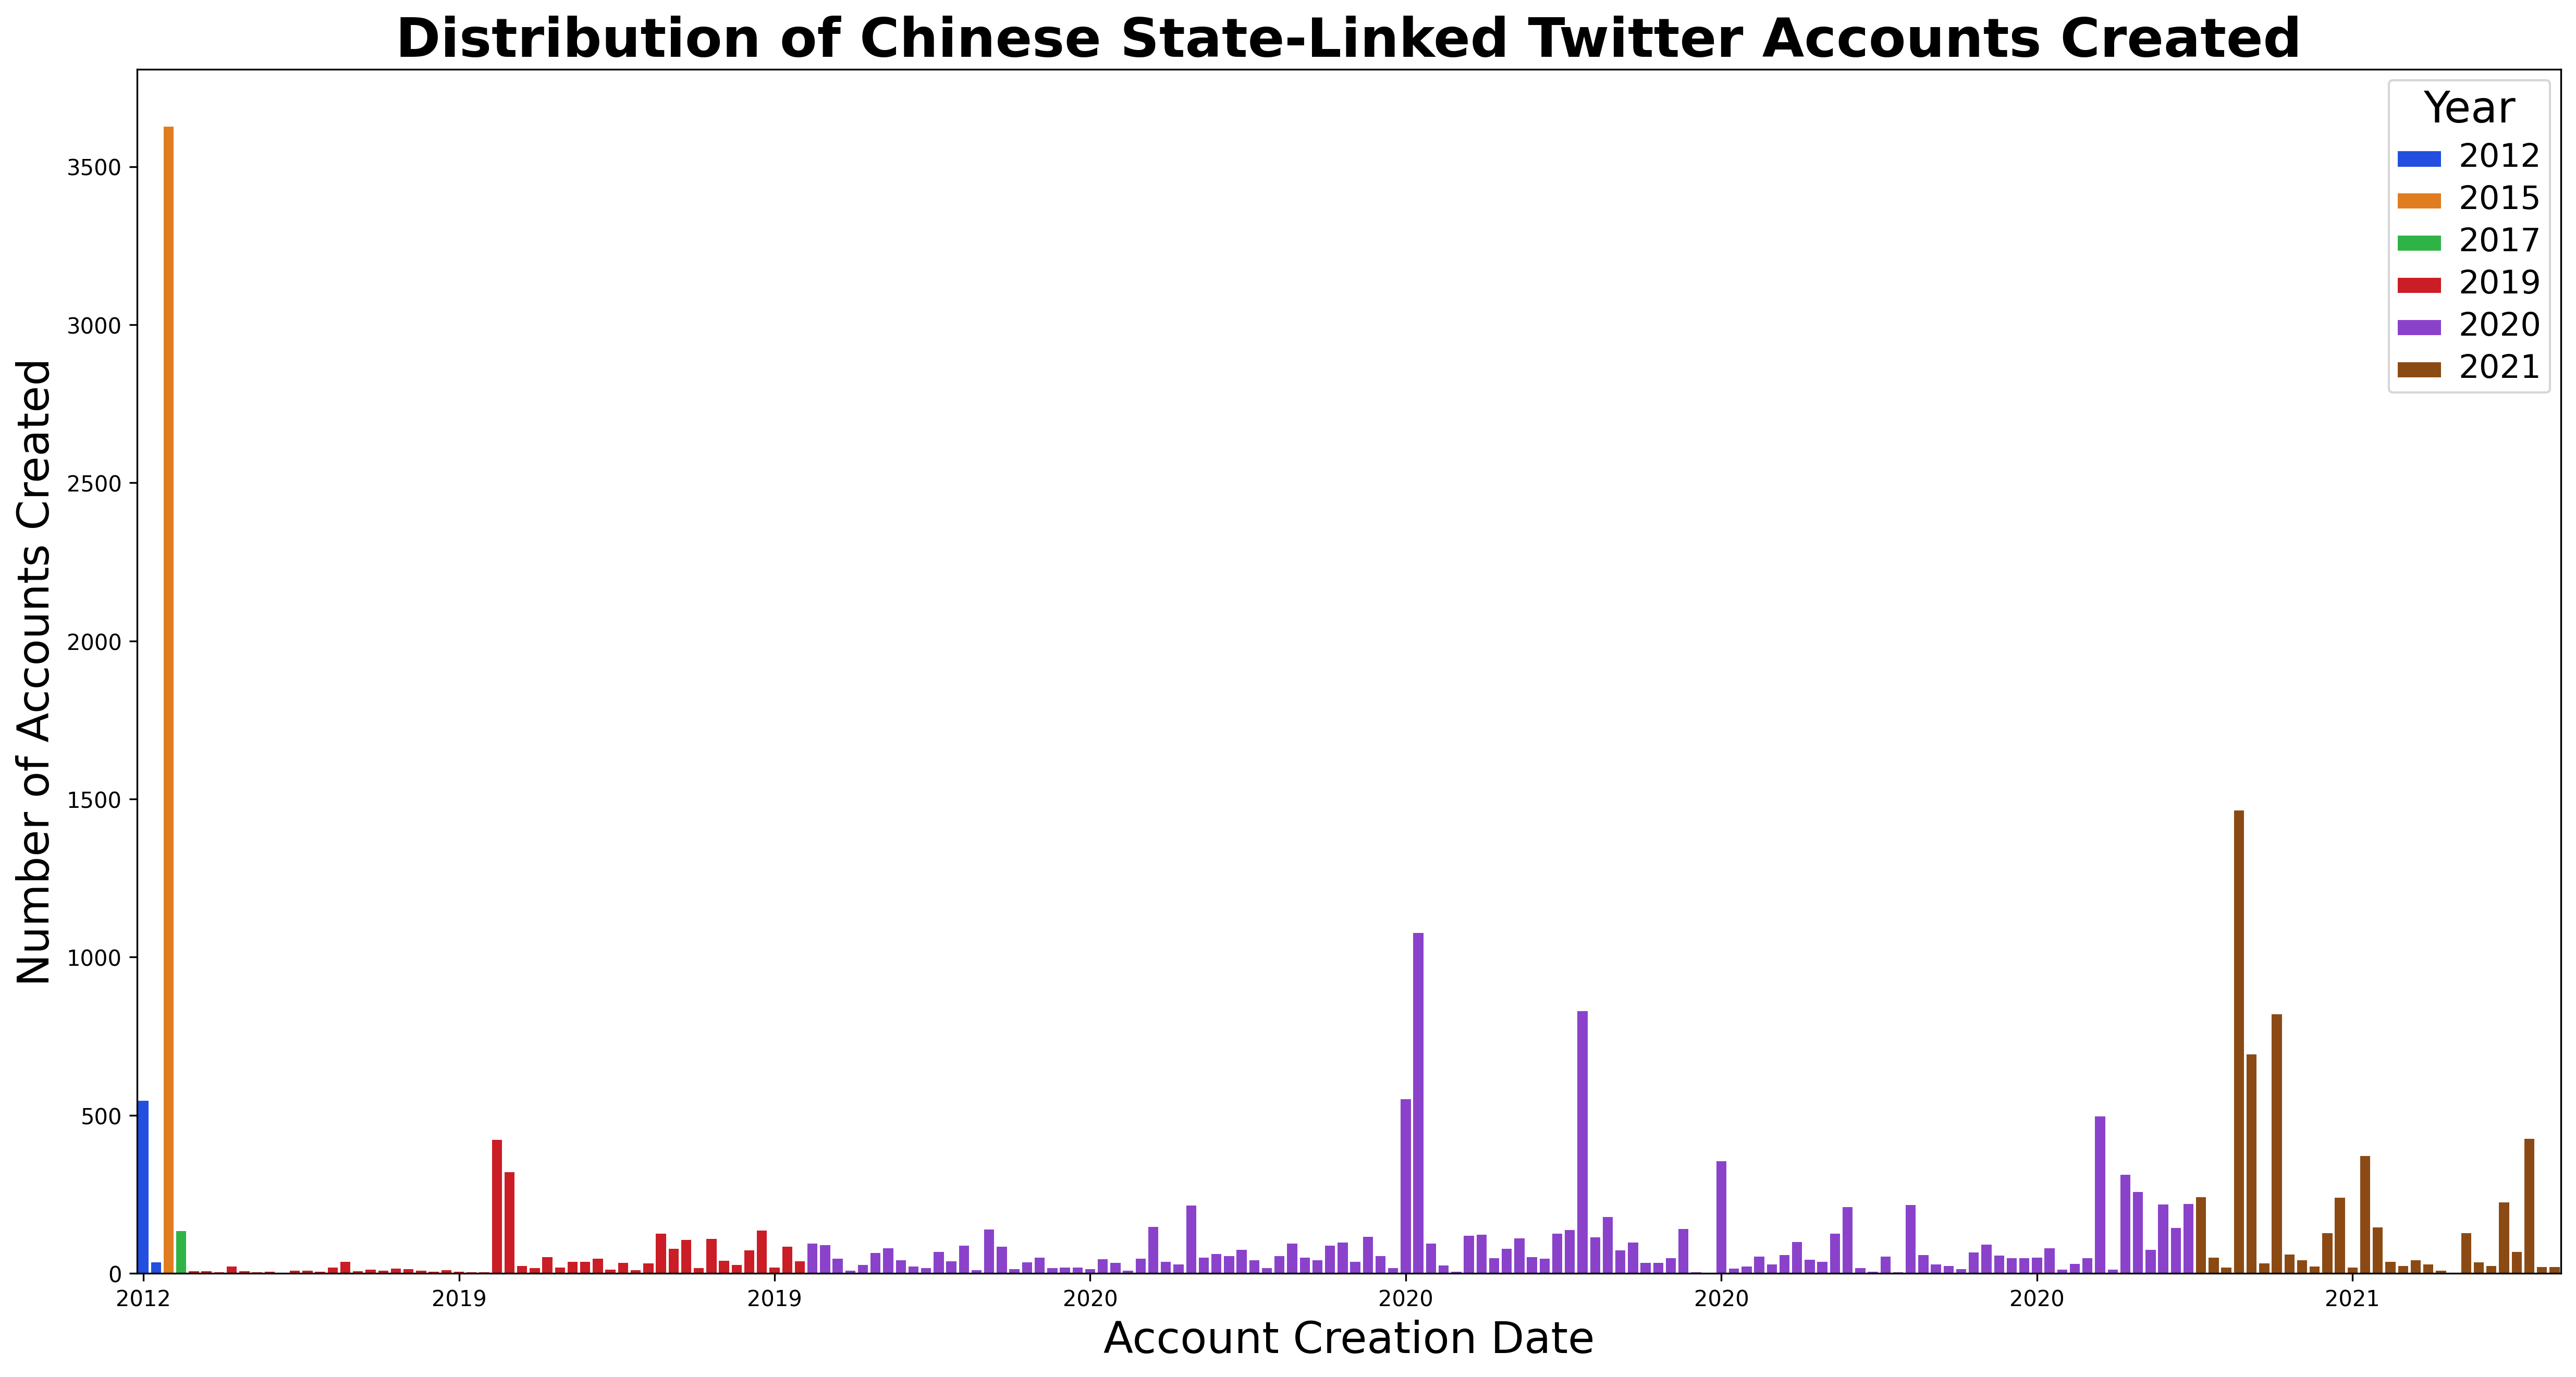

In [23]:
mpp.figure(1, (20, 10), dpi = 300)

# Get the current axis
ax = mpp.gca()

# Save a palette to a variable
palette = sns.color_palette('bright', n_colors = 6)
barplot = sns.barplot(df_acc_hist, x = 'account_creation_date', y = 'tweet_text', hue = 'Year', palette = palette)

mpp.title('Distribution of Chinese State-Linked Twitter Accounts Created', fontsize = 25, weight = 'bold')
mpp.ylabel('Number of Accounts Created', fontsize = 20); mpp.xlabel('Account Creation Date', fontsize = 20)

# Set the x labels
interval = 25
df_temp = df_acc_hist.loc[::interval]
ticks_to_use = df_temp.index
labels = df_temp['Year'].values

ax.set_xticks(ticks_to_use)
ax.set_xticklabels(labels)

# Legend settings
mpp.setp(barplot.get_legend().get_title(), fontsize = 20)
mpp.setp(barplot.get_legend().get_texts(), fontsize = 15)

mpp.savefig(plot_path + 'CN_account_dis.png', dpi = 300)
mpp.show()

In [24]:
df_acc_time['tweet_time'] = pd.to_datetime(df_acc_time['tweet_time'], format = '%Y-%m-%d')
df_acc_time['Year-Month'] = pd.to_datetime(df_acc_time['tweet_time']).dt.strftime('%Y-%m')
df_acc_time['Year'] = df_acc_time['tweet_time'].dt.year

# Groupby and count the number of tweets generated in that month in that year
df_tweet_hist = df_acc_time.groupby(['Year-Month', 'Year'])['tweet_text'].count().to_frame().reset_index()

# Sort by the most number of tweets generated in that month in that year
df_tweet_hist_max = df_tweet_hist.sort_values(by = ['tweet_text'], ascending = False)

# Select the top 100 most busiest year-month
df_tweet_hist_max = df_tweet_hist_max.iloc[:200]

In [25]:
df_tweet_hist_max.head()

Year-Month  Year  tweet_text
79    2021-01  2021        5394
81    2021-03  2021        3137
80    2021-02  2021        1980
69    2020-03  2020        1472
70    2020-04  2020        1417

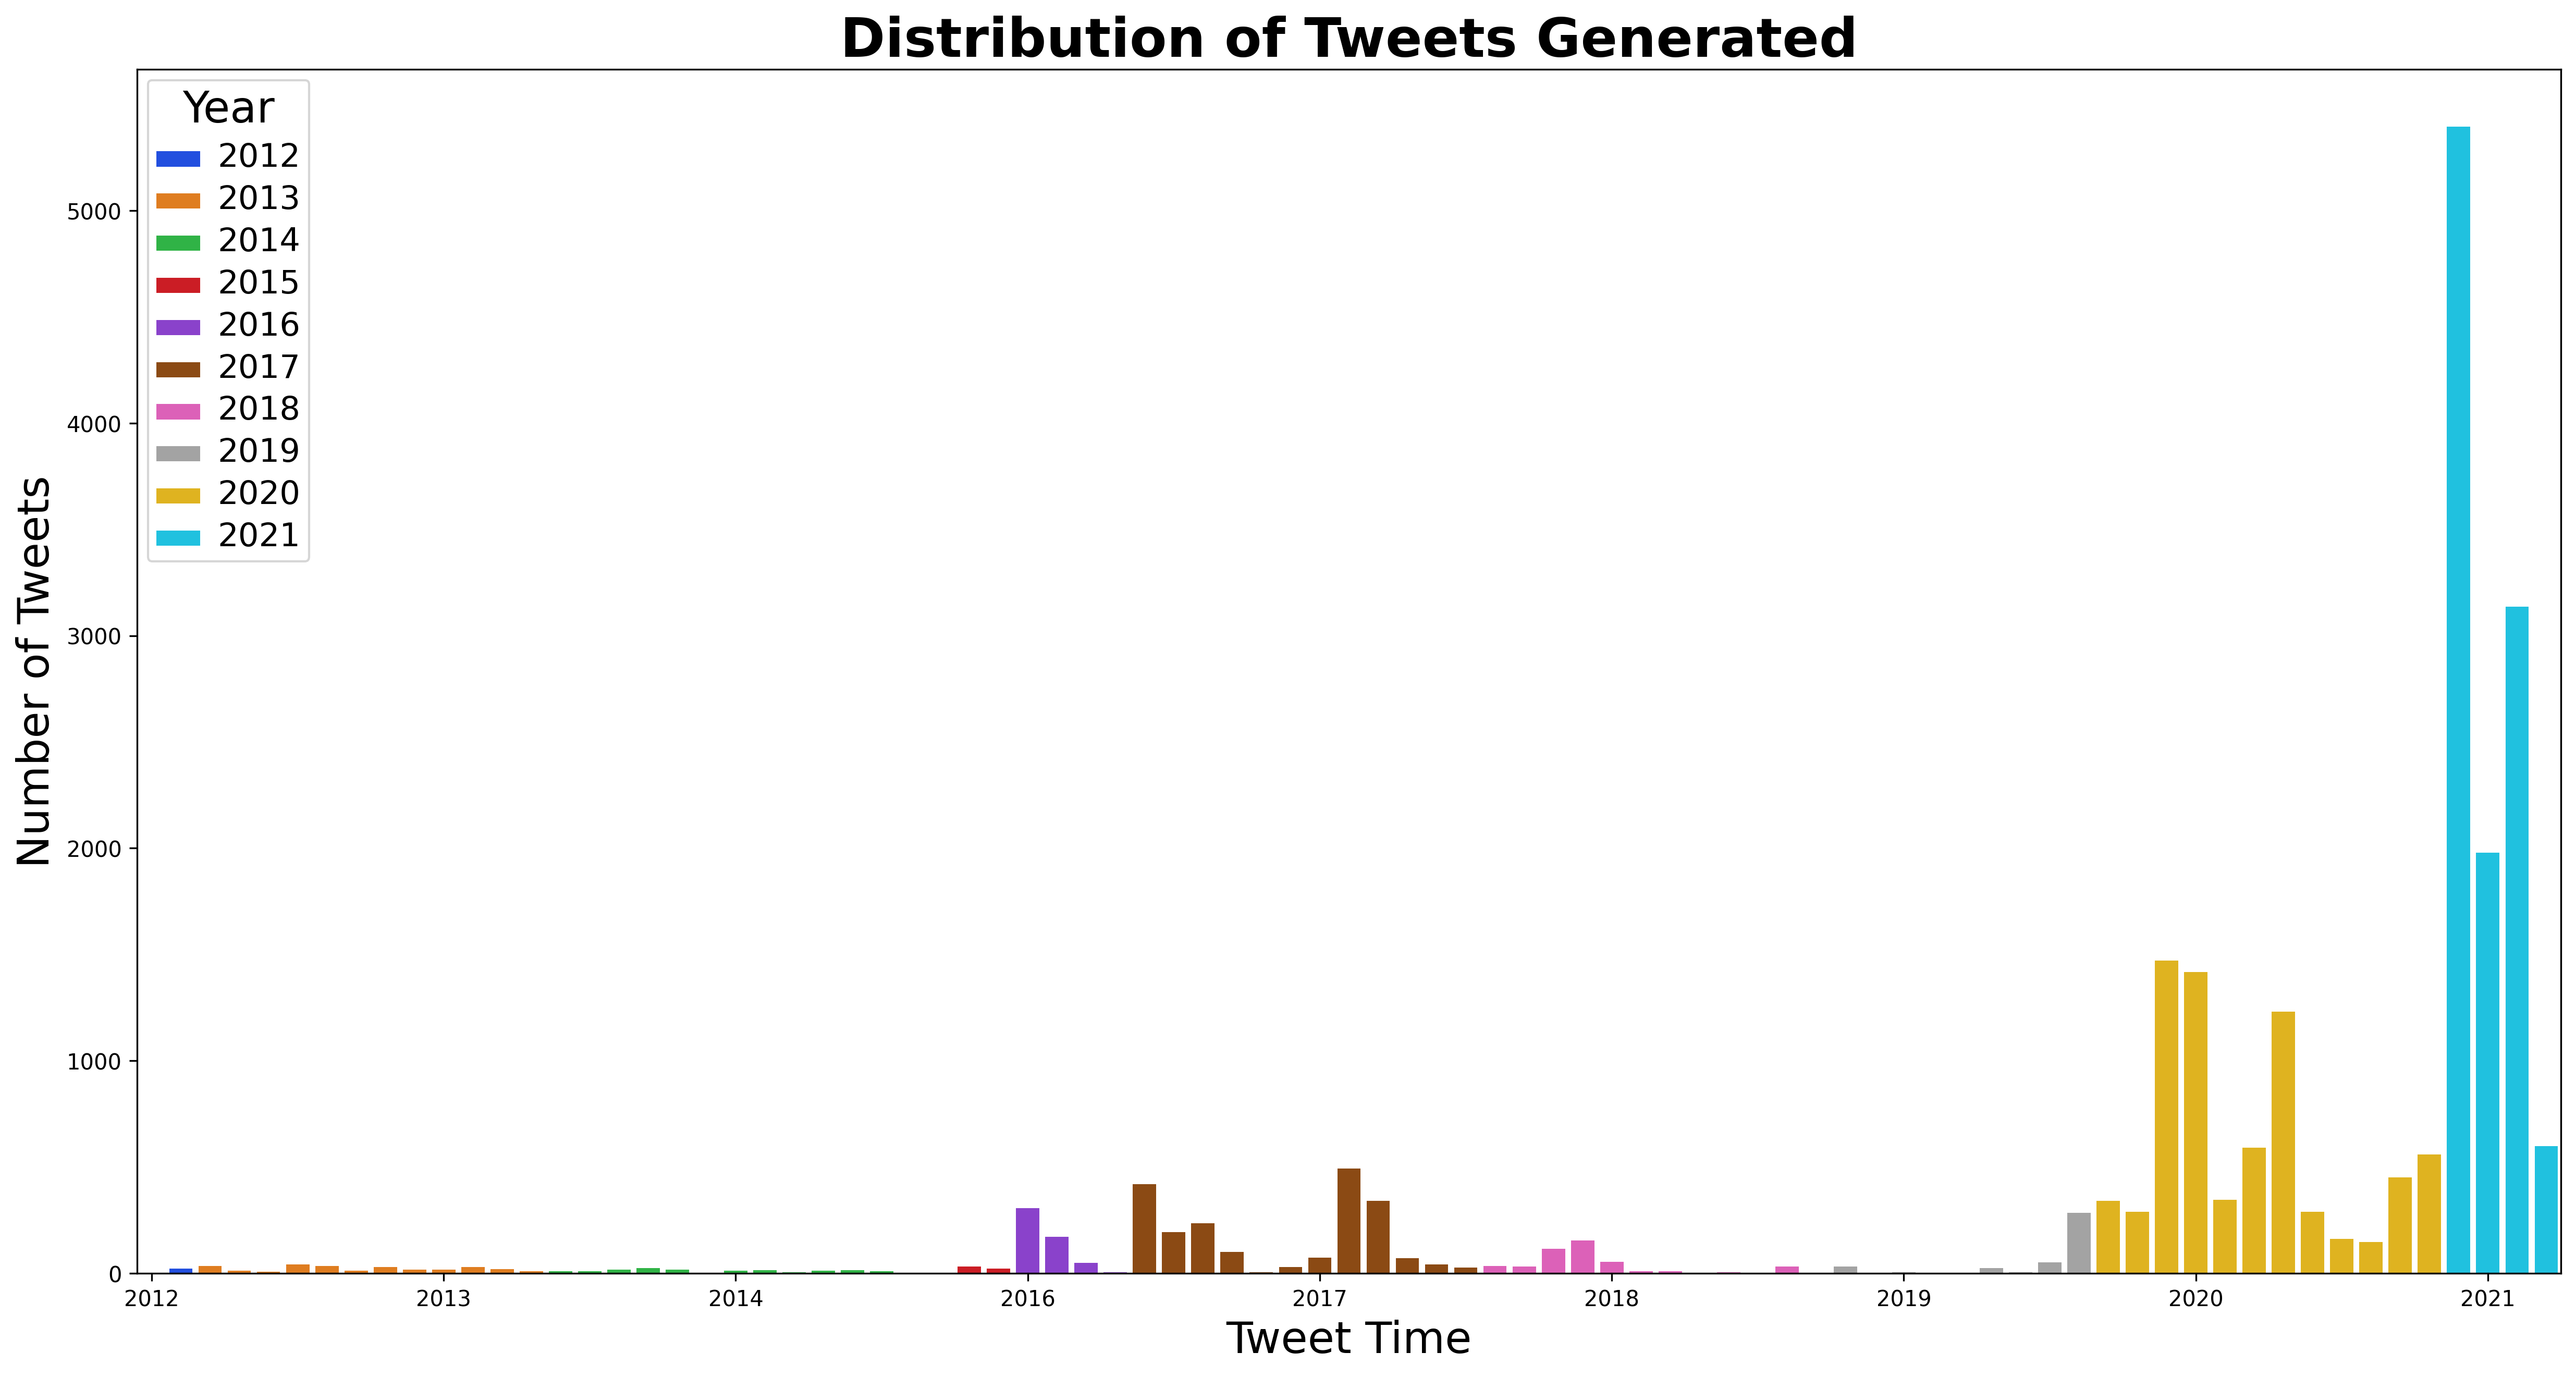

In [26]:
mpp.figure(1, (20, 10), dpi = 300)

# Get the current axis
ax = mpp.gca()

# Save a palette to a variable
palette = sns.color_palette('bright', n_colors = 10)
barplot = sns.barplot(df_tweet_hist, x = 'Year-Month', y = 'tweet_text', hue = 'Year', palette = palette)

mpp.title('Distribution of Tweets Generated', fontsize = 25, weight = 'bold')
mpp.ylabel('Number of Tweets', fontsize = 20); mpp.xlabel('Tweet Time', fontsize = 20)

# Set the x labels
interval = 10
df_temp = df_tweet_hist.loc[::interval]
ticks_to_use = df_temp.index
labels = df_temp['Year'].values

ax.set_xticks(ticks_to_use)
ax.set_xticklabels(labels)

# Legend settings
mpp.setp(barplot.get_legend().get_title(), fontsize = 20)
mpp.setp(barplot.get_legend().get_texts(), fontsize = 15)

mpp.savefig(plot_path + 'CN_tweet_dis.png', dpi = 300)
mpp.show()

## Hashtags Analysis

We want to figure out what kinds of hashtags are been used? We can put all of the hashtags in a giant list, and generate a word cloud through their tfidf scores.

But before this can be done, we need to clean up the hashtags column abit more. Because the column is of dtype object - that means we have strings of lists. We need to convert these strings of lists into list of lists. We then append all of the elements in each list into a large list of hashtags

In [27]:
df_hashtags = df_cn.copy()
df_hashtags = df_hashtags[df_hashtags['hashtags'].str.len() > 2].reset_index(drop = True)
hashtag_col_vals = df_hashtags['hashtags'].values
hashtag_col_vals

array(["['新疆是个好地方', 'Xinjiang', '新疆', 'Urumqi']",
       "['Xinjiang', 'Urumqi']", "['Xinjiang', 'Uygur']", ...,
       "['Pompeo']", "['Xinjiang', '新疆是个好地方', '新疆', '维吾尔族', 'Uyghurs']",
       "['Xinjiang']"], dtype=object)

In [28]:
hashtag_lists = [re.findall(r'[A-Za-z0-9]+', lst) for lst in hashtag_col_vals]

hashtags = [y for x in hashtag_lists for y in x]
print(f"Length of all hashtags : {len(hashtags)}")

Length of all hashtags : 12980


Now we can plot the wordcloud. We will restrict to the first 3000 hashtags to prevent Python from crashing

If there are errors in plotting the wordcloud, then have to switch to an appropriate version of Pillow

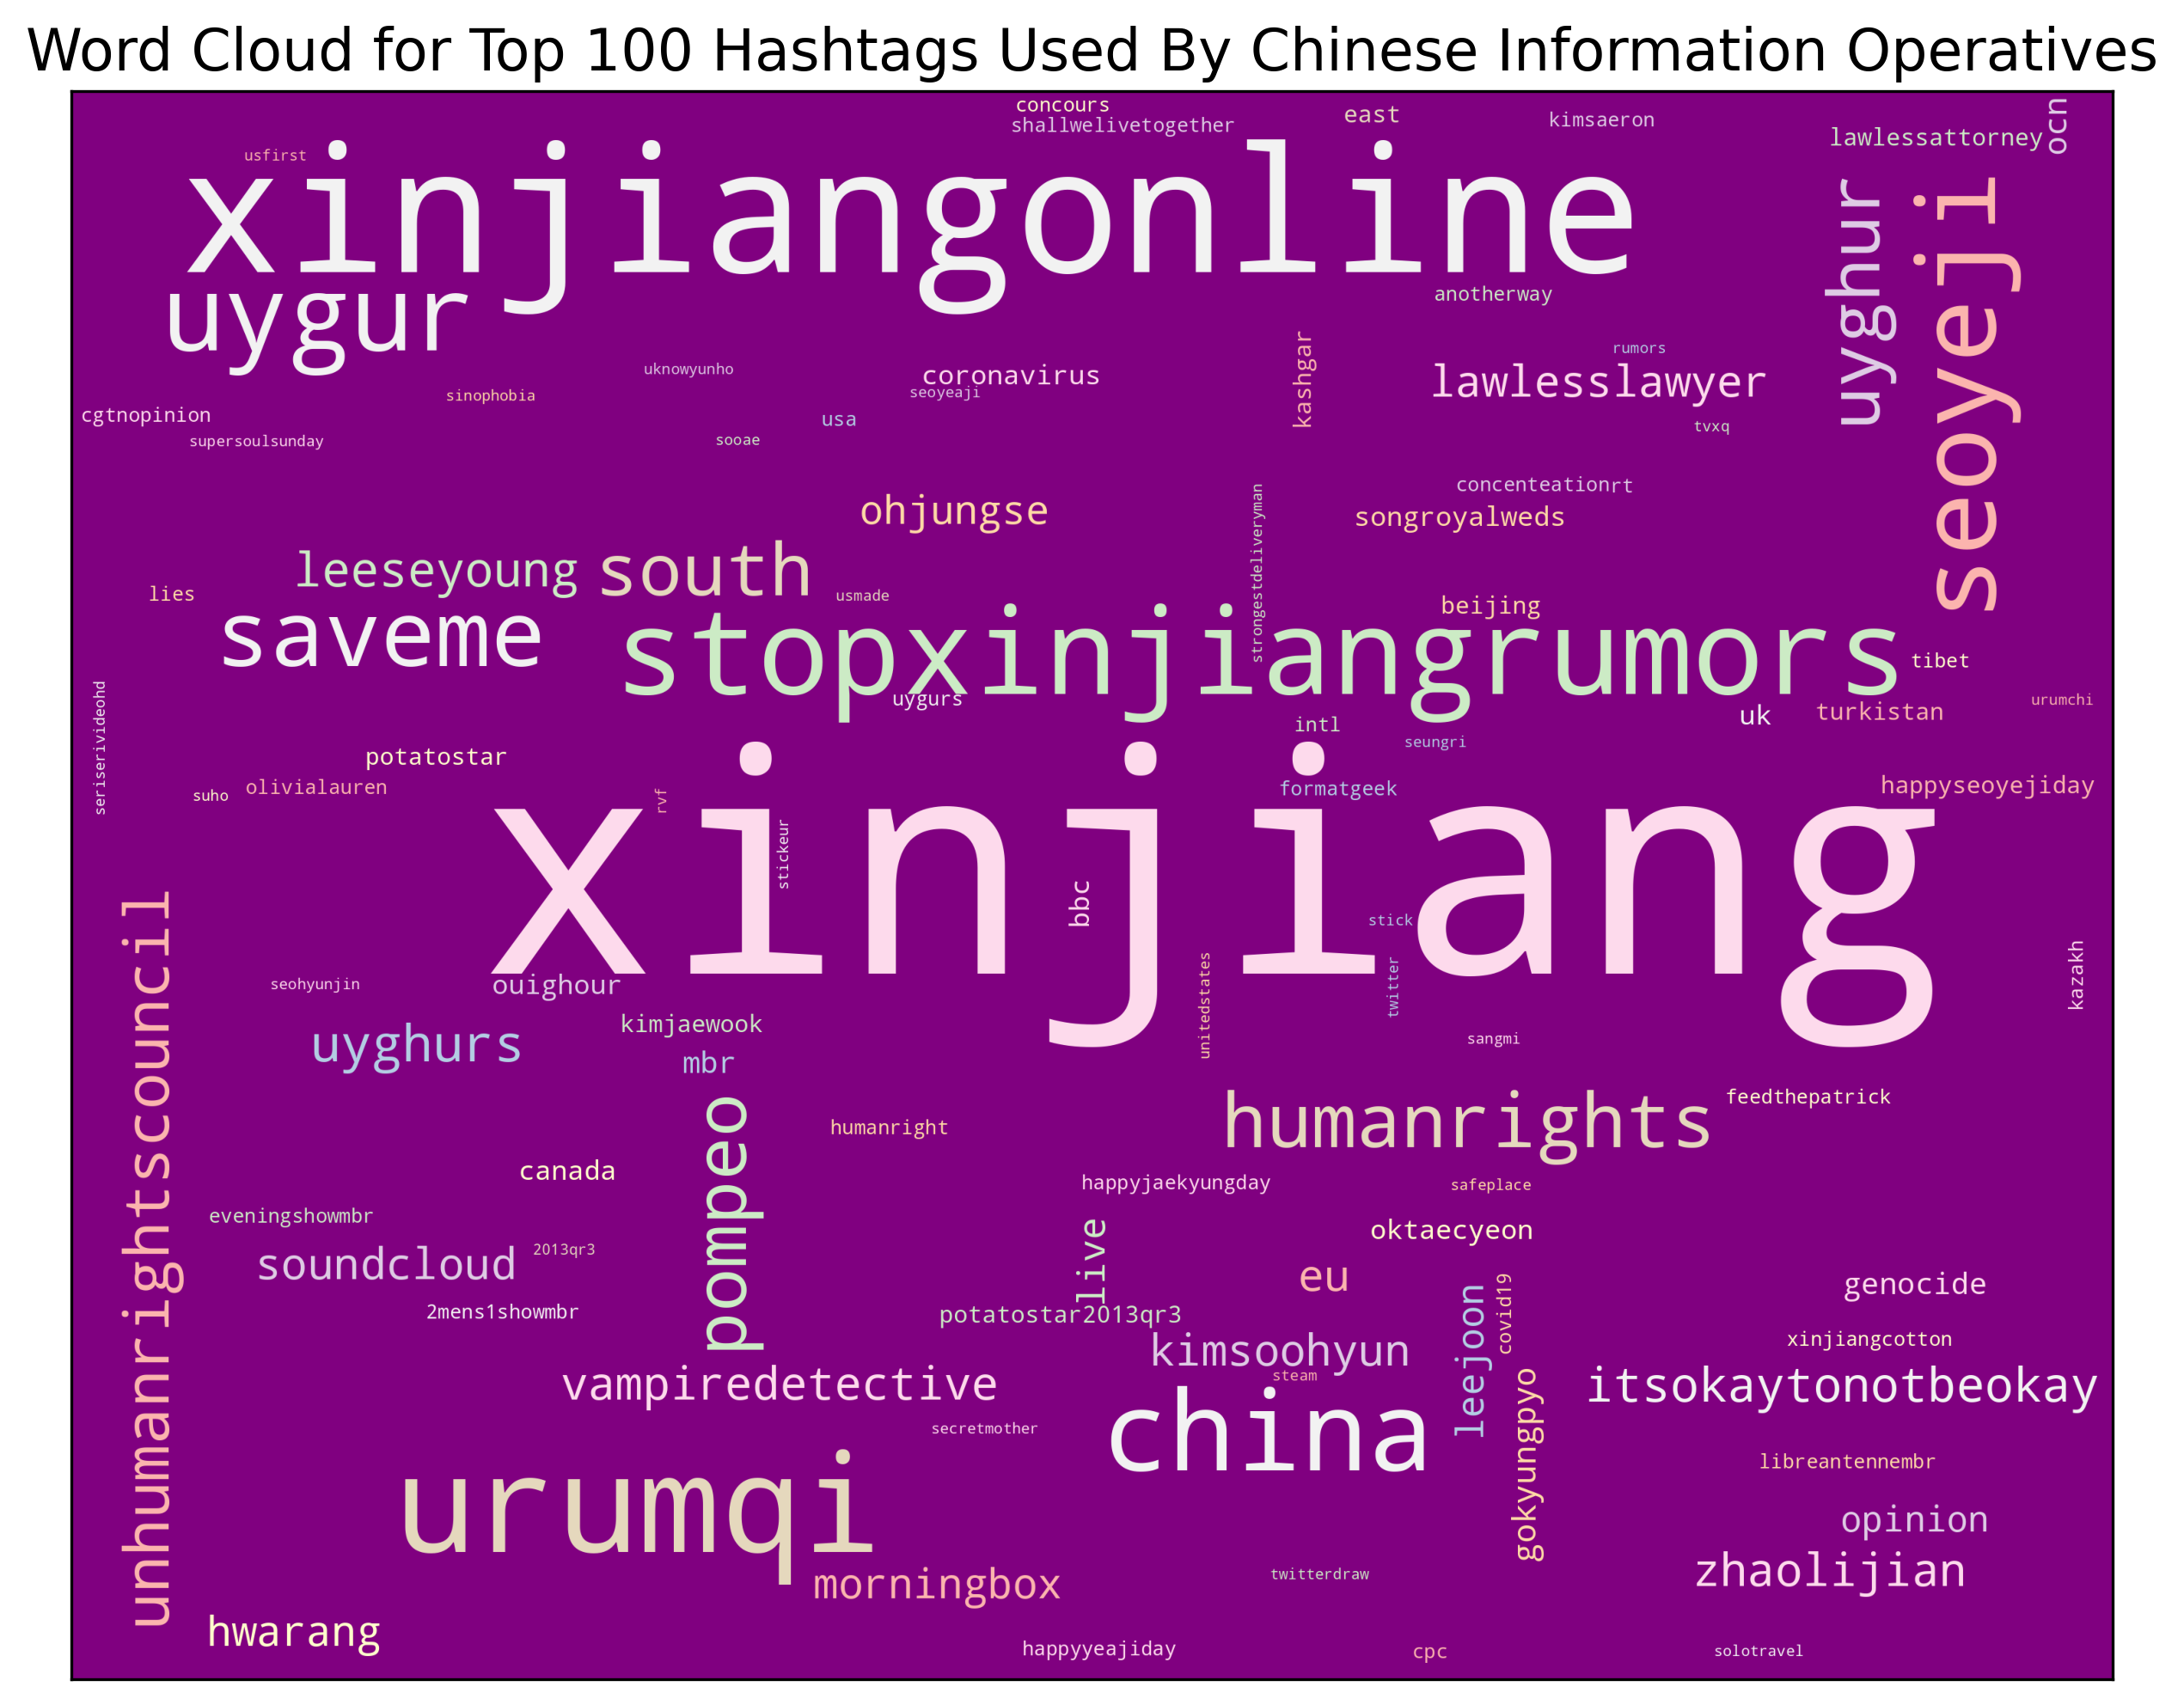

In [29]:
hashtags_word_feq = word_freq_tfidf(hashtags[:3000])

plot_wordcloud(hashtags_word_feq, 'purple', 'Pastel1', 100,
               'Word Cloud for Top 100 Hashtags Used By Chinese Information Operatives',
               3, 18, 8, plot_path + 'CN_hashtags_wordcloud.png')

## Profile Description Analysis

We use can create a wordcloud to exploit the profile description of the trolls. However, the text cleaning is slightly tricky, as we should not remove links and tags. So, we should aim to remove the special characters instead, and lowercase all the words.

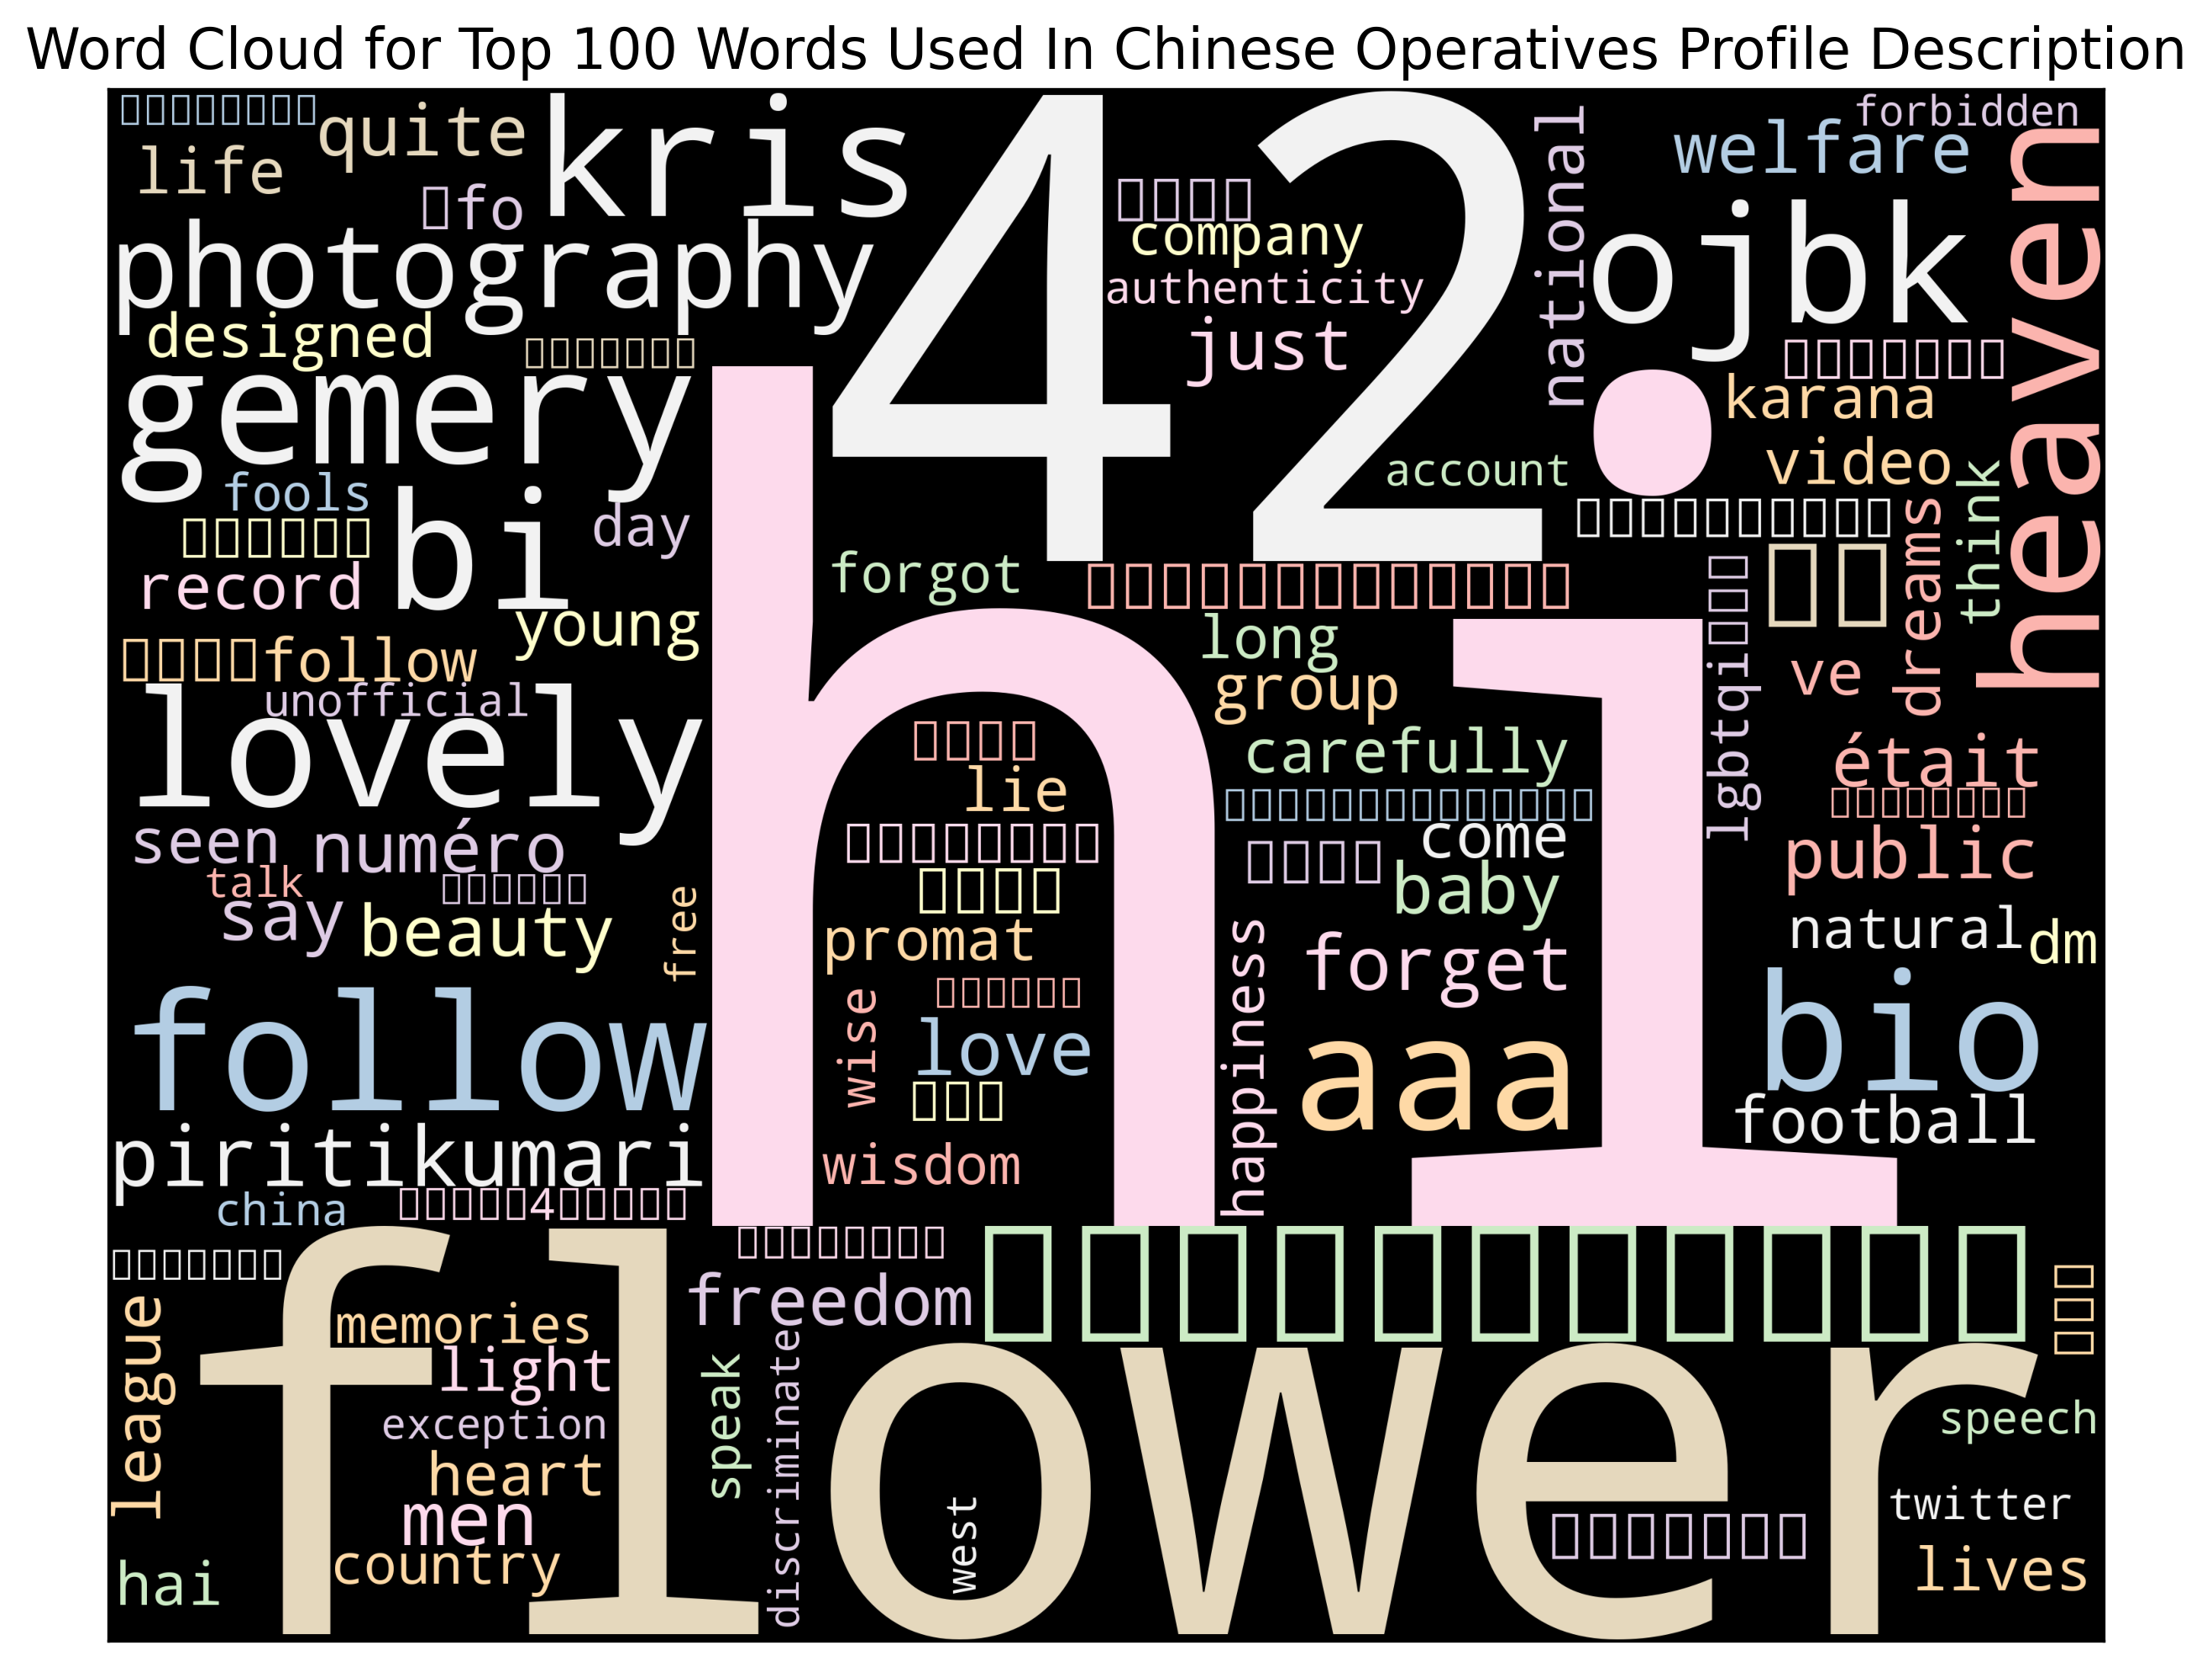

In [30]:
df_copy = df_cn.copy()
df_copy = df_copy.drop_duplicates(subset = ['user_display_name'])
df_copy = df_copy[df_copy['user_profile_description'].str.len() != 0]
df_copy['clean_description'] = df_copy['user_profile_description'].apply(lambda x : re.sub(r'#', '', x))
df_copy['clean_description'] = df_copy['clean_description'].apply(lambda x : re.sub(r'@', '', x).lower())

clean_description = df_copy['clean_description'].values

desc_feq = word_freq_tfidf(clean_description[:3000])

plot_wordcloud(desc_feq, 'black', 'Pastel1', 100,
               'Word Cloud for Top 100 Words Used In Chinese Operatives Profile Description',
               3, 18, 8, plot_path + 'CN_profile_wordcloud.png')

## Topics Evolution Analysis

This is something interesting to explore. We can ask ourselves: "How has Russian tradecraft changed from 2010 to 2020?" What different kinds of topics are the operatives targetting? We can groupby the tweets by on their tweet times into different years. We then plot individual word clouds for each of the years. This way, we can se the change in the topics and themes over the years. We would also need to clean the tweet text as well

We are only interested in English language tweets and we break up the English tweets into periods of 3 years

In [31]:
%%time
df_copy = df_cn.copy()
df_copy = df_copy[df_copy['tweet_language'] == 'en']
df_copy = df_copy[['tweet_time', 'tweet_text']].copy()

df_copy['tweet_year']       = df_copy['tweet_time'].dt.year
df_copy['clean_tweet_text'] = df_copy['tweet_text'].apply(text_processing)

df_copy.head(2)

CPU times: user 21 s, sys: 68.2 ms, total: 21.1 s
Wall time: 21.5 s


tweet_time                                           tweet_text  \
0 2020-12-13 05:14:00                 I can smell your perfume a mile away   
1 2021-03-28 08:21:00  #新疆是个好地方 #Xinjiang is a wonderful place #新疆 #Urumqi   

   tweet_year                      clean_tweet_text  
0        2020  i can smell your perfume a mile away  
1        2021    #新疆是个好地方  is a wonderful place #新疆

In [32]:
sorted(df_copy['tweet_year'].unique())

[2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]

We split up the dataframe into periods of 2 years each, since we have 10 years in total

In [33]:
df_2012_to_2013 = df_copy[df_copy['tweet_year'].isin([2012, 2013])]
df_2014_to_2015 = df_copy[df_copy['tweet_year'].isin([2014, 2015])]
df_2016_to_2017 = df_copy[df_copy['tweet_year'].isin([2016, 2017])]
df_2018_to_2019 = df_copy[df_copy['tweet_year'].isin([2018, 2019])]
df_2020_to_2021 = df_copy[df_copy['tweet_year'].isin([2020, 2021])]

Select the cleaned tweet text from each of the dataframes above and generate the word cloud!

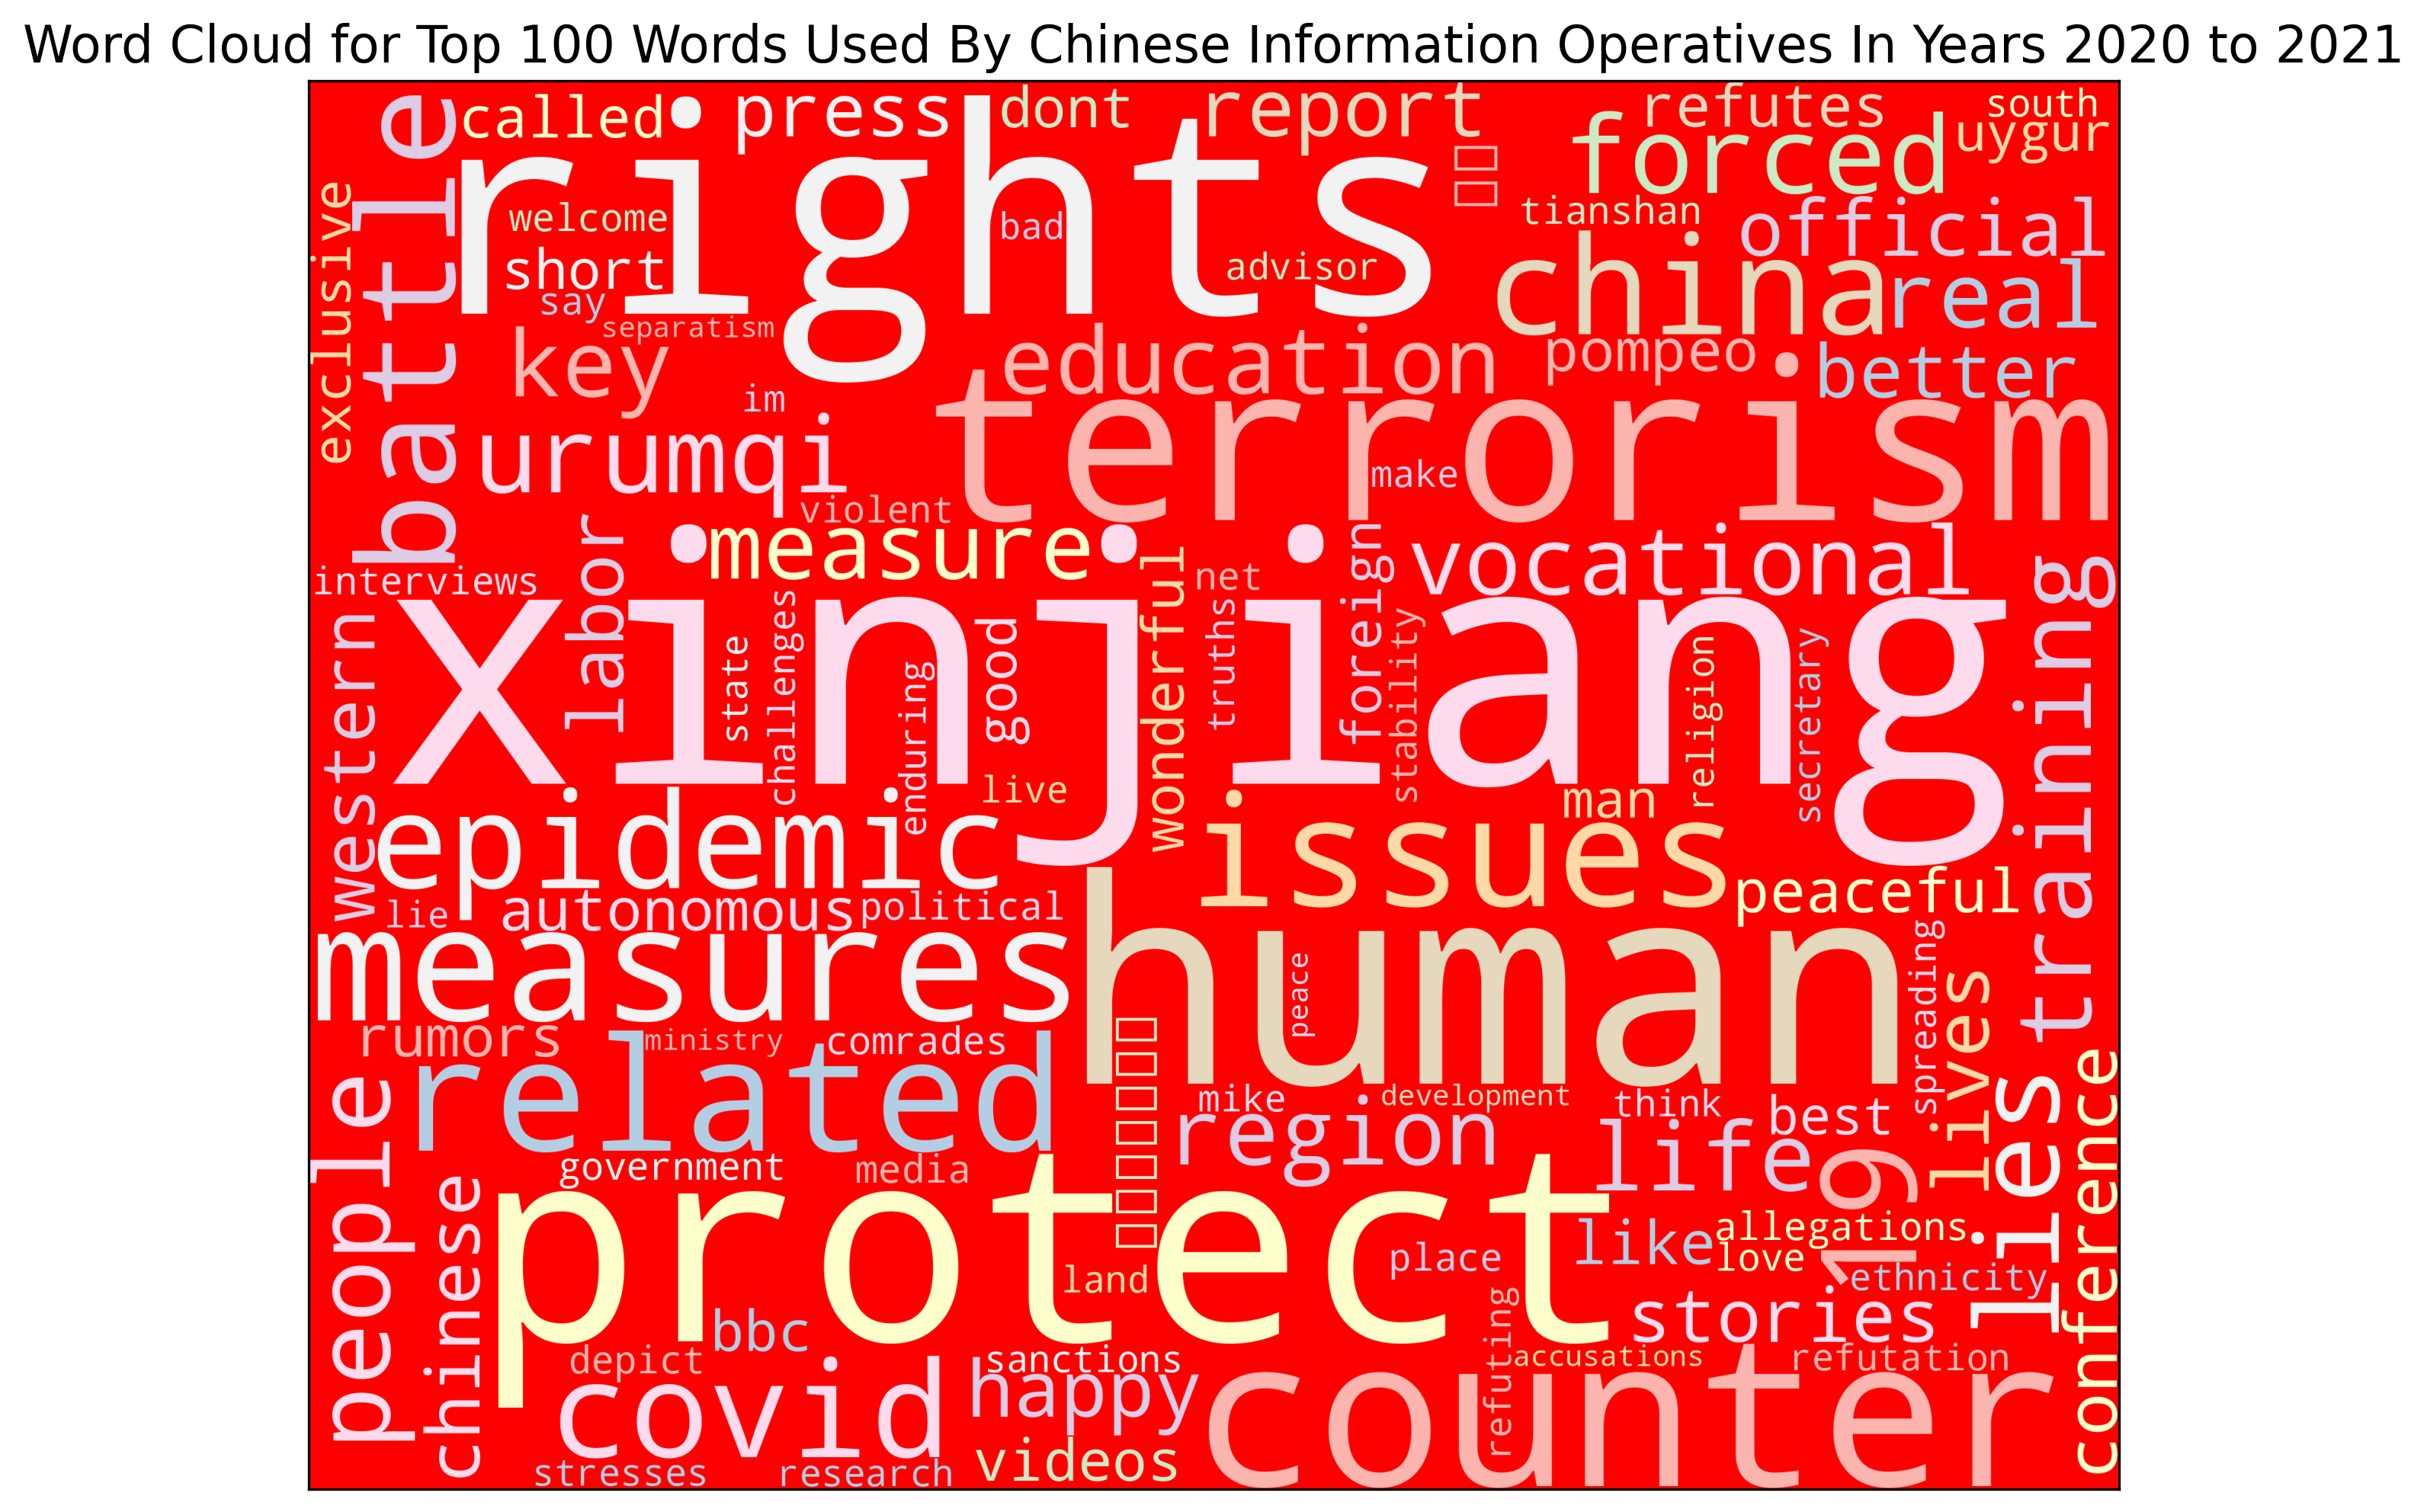

In [34]:
df_periods = [df_2012_to_2013, df_2014_to_2015, df_2016_to_2017, df_2018_to_2019, df_2020_to_2021]
periods    = ['2012 to 2013', '2014 to 2015', '2016 to 2017', '2018 to 2029', '2020 to 2021']
colors     = ['purple', 'green', 'orange', 'blue', 'red']

for i, df in enumerate(df_periods):
    tweet_text = df['clean_tweet_text']
    topic_word_feq = word_freq_tfidf(tweet_text[:2000])

    period = periods[i]

    plot_wordcloud(topic_word_feq, colors[i], 'Pastel1', 100,
               f'Word Cloud for Top 100 Words Used By Chinese Information Operatives In Years {period}',
               3, 18, 8, plot_path + f'CN_topic_evol_{period}.png')

We will load the cleaned dataframe here. Due to the limitations of Google Colab, we can only select a small fraction of the total cleaned tweets to perform topic modelling.

## Top 10 Words Used Most Frequently

Word frequency distribution plot

In [35]:
# there will be some rows that will be nan after all of the cleaning. We drop them
df_select = df_cn.dropna(subset = ['clean_tweet_text'])

print('Length of subdataframe for data viz:', len(df_select))
df_select.head(2)

Length of subdataframe for data viz: 22356


tweetid                                        userid  \
0  1337989285794889728  v5DYyk0D3VG4uiDVsWyRnuzBbudyVWlzaveF1bsGGg8=   
1  1376087059639595010  MmDNslrbaQ1LTocpODz7pSsyh1xE6Exe8sSHcLxateY=   

                              user_display_name  \
0  v5DYyk0D3VG4uiDVsWyRnuzBbudyVWlzaveF1bsGGg8=   
1  MmDNslrbaQ1LTocpODz7pSsyh1xE6Exe8sSHcLxateY=   

                               user_screen_name user_reported_location  \
0  v5DYyk0D3VG4uiDVsWyRnuzBbudyVWlzaveF1bsGGg8=                   NULL   
1  MmDNslrbaQ1LTocpODz7pSsyh1xE6Exe8sSHcLxateY=                   NULL   

  user_profile_description user_profile_url  follower_count  following_count  \
0                                                         0                5   
1                                                         0               22   

  account_creation_date account_language tweet_language  \
0            2020-03-31               en             en   
1            2021-01-19               en             en   

                                            tweet_text          tweet_time  \
0                 I can smell your perfume a mile away 2020-12-13 05:14:00   
1  #新疆是个好地方 #Xinjiang is a wonderful place #新疆 #Urumqi 2021-03-28 08:21:00   

  tweet_client_name in_reply_to_userid in_reply_to_tweetid  \
0   Twitter Web App                                          
1   Twitter Web App                                          

    quoted_tweet_tweetid is_retweet retweet_userid retweet_tweetid latitude  \
0                             False                                  absent   
1  1.373918657508565e+18      False                                  absent   

  longitude quote_count reply_count like_count retweet_count  \
0    absent           0           0          0             0   
1    absent           0           0          0             0   

                                  hashtags urls user_mentions\r  \
0                                       []   []            []\r   
1  ['新疆是个好地方', 'Xinjiang', '新疆', 'Urumqi']   []            []\r   

                       clean_tweet_text  
0  i can smell your perfume a mile away  
1    #新疆是个好地方  is a wonderful place #新疆

In [36]:
cn_clean_tweet_text = df_select['clean_tweet_text'].to_list()

Similarly in the utilities module, we have define some functions that we will be using to plot the data visualizations. We generate the word frequencies from using the tfidf function. As an example, let us print the top 10 words with the highest tdidf scores.

In [37]:
word_feq = word_freq_tfidf(cn_clean_tweet_text[:2000])
word_feq[:10]

xinjiang     87.253643
rights       55.430235
human        54.509462
protect      50.379977
terrorism    47.818015
related      45.391724
counter      43.458548
measures     42.459068
issues       42.458417
china        32.761132
dtype: float64

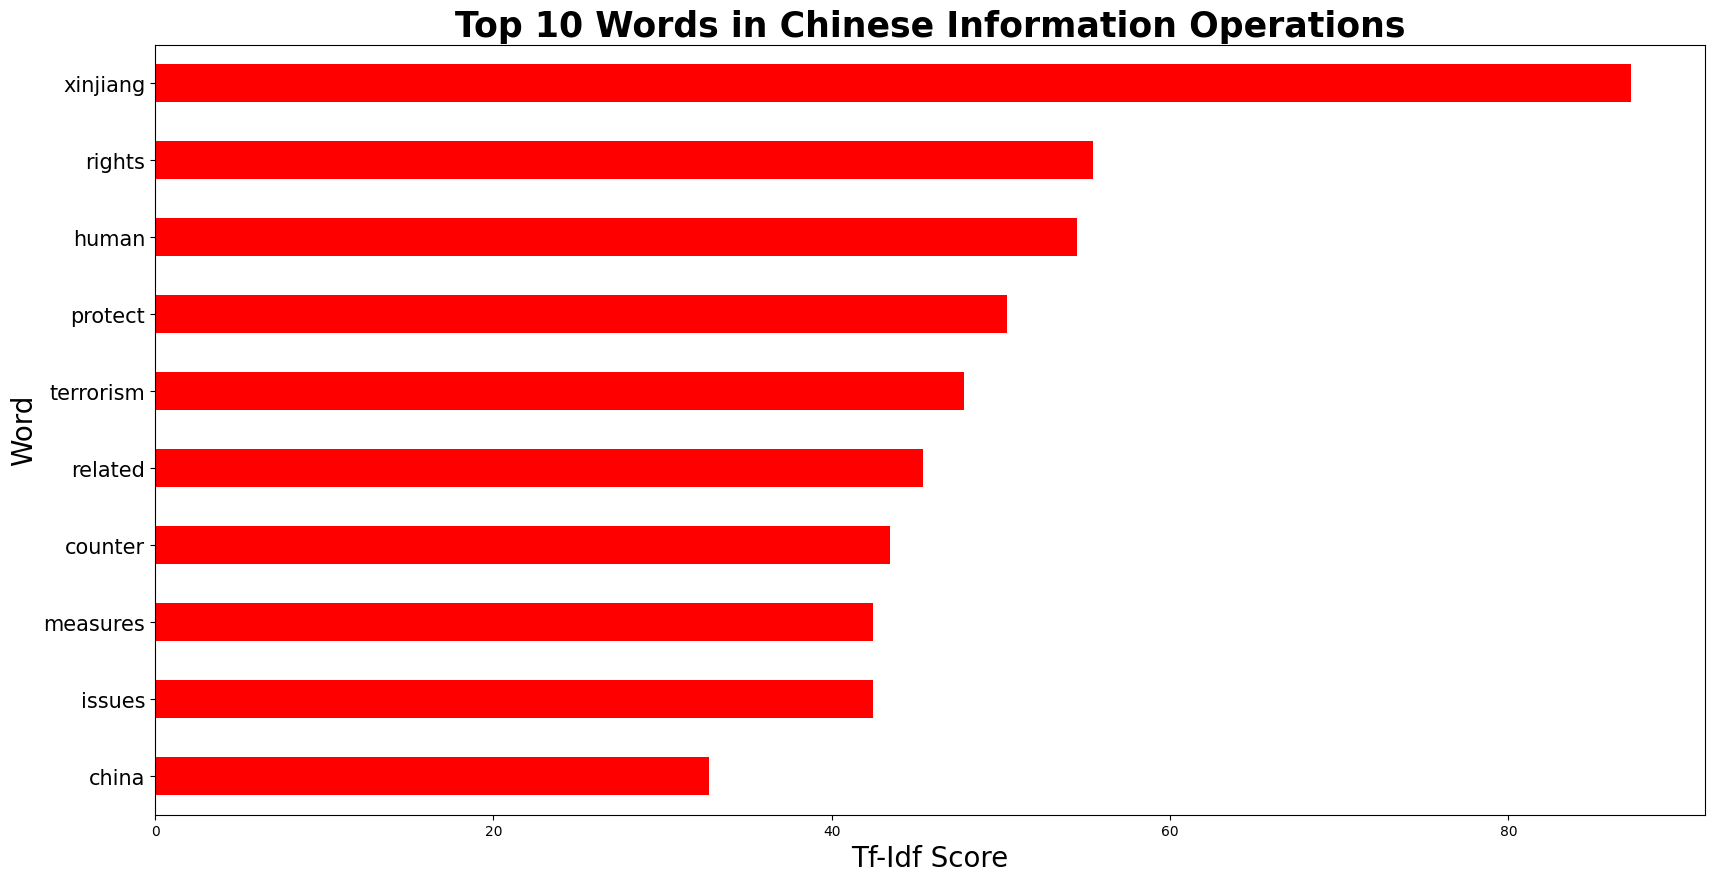

In [38]:
word_distribution(word_feq, 10, 'red', 1, (20, 10),
                  'Top 10 Words in Chinese Information Operations',
                  'Tf-Idf Score',
                  'Word',
                   plot_path + 'CN_word_frequency.png')

## Topic Modelling

Topic modelling refers to the clustering of topics and common themes the state actors commonly use. We can use the package BERTopic to achieve  this objective.

In [ ]:
# set up BERTopic model
topic_model      = BERTopic(verbose = True)
topics_cn, probs = topic_model.fit_transform(cn_clean_tweet_text)

2024-03-16 10:59:44,451 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 699/699 [00:09<00:00, 76.79it/s] 
2024-03-16 10:59:56,131 - BERTopic - Embedding - Completed ✓
2024-03-16 10:59:56,132 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-03-16 11:00:14,982 - BERTopic - Dimensionality - Completed ✓
2024-03-16 11:00:14,983 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-03-16 11:00:16,253 - BERTopic - Cluster - Completed ✓
2024-03-16 11:00:16,262 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-03-16 11:00:17,158 - BERTopic - Representation - Completed ✓


We will plot and save a total of 200 topics that appear in the dataset.

In [ ]:
%%time
# Generate word cloud and save the topic word clouds
for i in range(200):
    topic_wordcloud(topic_model = topic_model, topic = i, country = 'CN', width = 15, height = 6, data_path = plot_path)

---
# **Evaluation**
---

We present a summary of the findings from our analysis above:

- Overal, Chinese information operations display a precise, focused and concerted effort in just issue - Xinjiang. In particular, the denial of human rights abuses in Xinjiang. The Chinese operations appear to attack international critics of the harsh treatments of Uyghurs, by justifying that these measures are in a attempt to stop or prevent terrorism, and separatism from taking place in China. They deny these allegations and decry their critics to stop spreading rumors about Xinjiang.

- Like Russia, Chinese information operations took place as early as 2012, which the first troll accounts were created and first tweets were made. Howevewr, the wordclouds does not seem to display a pattern in the kinds of tweets that the trolls were tweeting, nor do they show any consistency in the topics they were trying to exploit from years 2012 to 2019. However, the wordcloud for 2020 to 2021 show the most glaring change, then words such as **xinjiang**, **human**, **rights**, **protect** appeared most frequently in the trolls' tweets. Furthermore, the hashtags also show that the trolls were trying to paint a rosy picture of the treatment of Uyghur people in Xinjiang, calling to **stopxinjaingrumors**.

- The wordclouds in from the topic modelling section is extremely invaluable, because it shows the kinds of topics that the operatives are tweeting. The overarching focus of the operatives is to deny any mistreatmnet against the Uyghur populace, by the Chinese government. The operatives attempt to achieve this 'justifying' that:
    - the Chinese government has fully protected and respected human rights, the measures in Xinjiang is pursely for counterrorism
    - educating the Uyghur populace is key to preventing extremism
    - the hash measures is to battle COVID-19 pandemic


- Furthermore, the operatives want to gaslight the international community into thinking that:
    - the populace in Xinjiang is happy, peaceful and fullfilled through videos
    - there is no forced labour in Xinjiang
    - BBC is spreading rumors and lying about the situation in Xinjiang
    - western media is fabrication false allegations about Xinjiang
